# Detecting building defects using image classification

A deep learning model that detects faults in building. The defects are - Roof defect, Cracks and Flakes on walls.

## Import dataset

In [ ]:
# Import dataset from local device (If you are using google colab.)
from google.colab import files
uploaded = files.upload()

# else put the data in the working directory and skip the next step.

In [3]:
import zipfile

zip_ref = zipfile.ZipFile('data.zip')
zip_ref.extractall()
zip_ref.close()

In [5]:
# walk through the dataset
import pathlib
import os

for dirpath, dirnames , filenames in os.walk('data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in data
There are 3 directories and 0 images in data/train_set
There are 0 directories and 54 images in data/train_set/roof
There are 0 directories and 176 images in data/train_set/flakes
There are 0 directories and 86 images in data/train_set/crack
There are 3 directories and 0 images in data/test_set
There are 0 directories and 37 images in data/test_set/roof
There are 0 directories and 51 images in data/test_set/flakes
There are 0 directories and 32 images in data/test_set/crack


In [8]:
# get the classnames
import numpy as np
data_dir = pathlib.Path("data/train_set/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['crack' 'flakes' 'roof']


In [10]:
# visualize the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  dir_name = target_dir + target_class
  random_img = random.sample(os.listdir(dir_name), 1)

  img = mpimg.imread(dir_name + '/' + random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)
  print(f'image shape : {img.shape}')

image shape : (408, 612, 3)


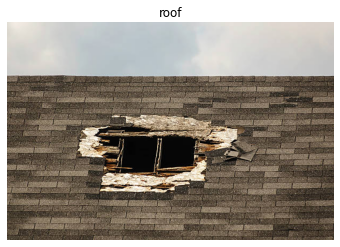

In [16]:
view_random_image('data/train_set/', 'roof')

## Create an efficient input pipeline


In [29]:
import tensorflow as tf
from glob import glob

In [28]:
# All the constants
IMG_SIZE = 224

In [39]:
classes = os.listdir('data/train_set')
classes

['roof', 'flakes', 'crack']

In [51]:
# create a function to return a dataset

def create_train_dataset(path):
  
  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_image(image, channels = 3, expand_animations = False)
    image = tf.image.resize(image ,[IMG_SIZE, IMG_SIZE])
    return image

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  random.shuffle(filenames)
  labels = [classes.index(name.split('/')[-2]) for name in filenames]

  filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filename_ds.map(parse_image, num_parallel_calls = tf.data.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds , labels_ds))

  return ds

def create_test_dataset(path):
  
  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_image(image, channels = 3, expand_animations = False)
    image = tf.image.resize(image ,[IMG_SIZE, IMG_SIZE])
    return image

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  # random.shuffle(filenames)
  labels = [classes.index(name.split('/')[-2]) for name in filenames]

  filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filename_ds.map(parse_image, num_parallel_calls = tf.data.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds , labels_ds))

  return ds

In [118]:
train_ds = create_train_dataset('data/train_set')
train_ds

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [119]:
test_ds = create_test_dataset('data/test_set')
test_ds

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [120]:
# Performance improvement
train_ds = train_ds.shuffle(buffer_size = 1).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(buffer_size= tf.data.AUTOTUNE)

In [121]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [122]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

## Creating the model

In [212]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = preprocessing.RandomFlip('horizontal')(inputs)
x = preprocessing.RandomHeight(0.2)(x)
x = preprocessing.RandomWidth(0.2)(x)
x = preprocessing.RandomZoom(0.2)(x)
# x = preprocessing.RandomRotation(0.2)(x)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_pooling_layer')(x)
x =  layers.Dropout(0.4)(x)
x = layers.Dense(256, activation = 'relu')(x)
x =  layers.Dropout(0.7)(x)
x = layers.Dense(128, activation = 'relu')(x)
x =  layers.Dropout(0.7)(x)
x = layers.Dense(len(classes))(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'output_layer')(x)

# Connect the model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [213]:
model_1.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_29 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_height_29 (RandomHei  (None, None, 224, 3)     0         
 ght)                                                            
                                                                 
 random_width_21 (RandomWidt  (None, None, None, 3)    0         
 h)                                                              
                                                                 
 random_zoom_22 (RandomZoom)  (None, None, None, 3)    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  40

In [214]:
# Training the model
history_1 = model_1.fit(train_ds,
                        epochs = 20,
                        steps_per_epoch = len(train_ds),
                        validation_data = test_ds,
                        validation_steps = len(test_ds))

Epoch 1/20
10/10 [==============================] - 12s 472ms/step - loss: 1.3339 - accuracy: 0.4842 - val_loss: 0.9578 - val_accuracy: 0.4667
Epoch 2/20
10/10 [==============================] - 3s 279ms/step - loss: 1.1568 - accuracy: 0.5158 - val_loss: 0.7876 - val_accuracy: 0.6167
Epoch 3/20
10/10 [==============================] - 2s 231ms/step - loss: 1.0158 - accuracy: 0.5854 - val_loss: 0.6998 - val_accuracy: 0.7000
Epoch 4/20
10/10 [==============================] - 3s 277ms/step - loss: 0.9053 - accuracy: 0.6171 - val_loss: 0.6503 - val_accuracy: 0.7250
Epoch 5/20
10/10 [==============================] - 3s 253ms/step - loss: 0.8750 - accuracy: 0.6234 - val_loss: 0.6103 - val_accuracy: 0.7500
Epoch 6/20
10/10 [==============================] - 3s 300ms/step - loss: 0.7291 - accuracy: 0.6741 - val_loss: 0.5829 - val_accuracy: 0.7833
Epoch 7/20
10/10 [==============================] - 3s 294ms/step - loss: 0.7023 - accuracy: 0.7025 - val_loss: 0.5543 - val_accuracy: 0.8000
Epoch

## Downloading model

In [124]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

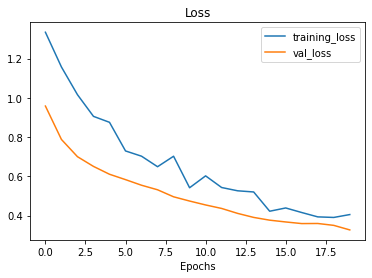

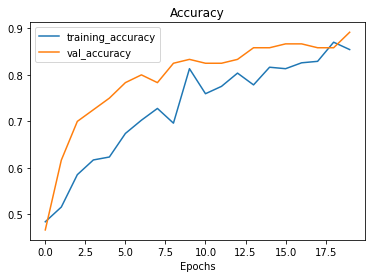

In [215]:
plot_loss_curves(history_1)

In [202]:
# Download the model
model_1.save("Building_defect_detection_model_NEW.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Fine tuning model

In [203]:
model_1.save_weights("model_1_new.h5", overwrite = True)

In [216]:
# make base model trainable
base_model.trainable = True

# Now freeze all layers except last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [217]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_32 False
rescaling_31 False
normalization_31 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv Fa

In [218]:
# Recompile model
model_1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [219]:
# fit the model
history_fine_tuned = model_1.fit(train_ds,
                                 epochs = 30,
                                 steps_per_epoch = len(train_ds),
                                 validation_data = test_ds,
                                 validation_steps = len(test_ds),
                                 initial_epoch = history_1.epoch[-1])

Epoch 20/30
10/10 [==============================] - 12s 459ms/step - loss: 0.4609 - accuracy: 0.8323 - val_loss: 0.3898 - val_accuracy: 0.8333
Epoch 21/30
10/10 [==============================] - 3s 291ms/step - loss: 0.3627 - accuracy: 0.8639 - val_loss: 0.3317 - val_accuracy: 0.8833
Epoch 22/30
10/10 [==============================] - 2s 242ms/step - loss: 0.3198 - accuracy: 0.8924 - val_loss: 0.3428 - val_accuracy: 0.8917
Epoch 23/30
10/10 [==============================] - 3s 313ms/step - loss: 0.2130 - accuracy: 0.9209 - val_loss: 0.4031 - val_accuracy: 0.8667
Epoch 24/30
10/10 [==============================] - 2s 250ms/step - loss: 0.1808 - accuracy: 0.9367 - val_loss: 0.3363 - val_accuracy: 0.8917
Epoch 25/30
10/10 [==============================] - 2s 254ms/step - loss: 0.1516 - accuracy: 0.9399 - val_loss: 0.3807 - val_accuracy: 0.9000
Epoch 26/30
10/10 [==============================] - 3s 340ms/step - loss: 0.1198 - accuracy: 0.9525 - val_loss: 0.4545 - val_accuracy: 0.891

In [187]:
def compare_historys(original_history, new_history, initial_epoch = 5):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_loss = original_history.history['val_loss']
  val_accuracy = original_history.history['val_accuracy']

  # combining original history with new history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_accuracy + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # make the plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label= 'Training accuracy')
  plt.plot(total_val_acc, label='validation accuracy')
  plt.plot([initial_epoch-1, initial_epoch-1],
           plt.ylim(), label = 'Start fine tuning')
  plt.legend(loc = 'lower right')
  plt.title('Traingin and validation accuracy')

  plt.subplot(2,1,2)
  plt.plot(total_loss, label = 'training loss')
  plt.plot(total_val_loss, label = 'validation loss')
  plt.plot([initial_epoch-1, initial_epoch-1],
           plt.ylim(), label = 'Start fine tuning')
  plt.legend(loc = 'upper right')
  plt.title('Training and validation loss')
  plt.xlabel('epoch')
  plt.show()

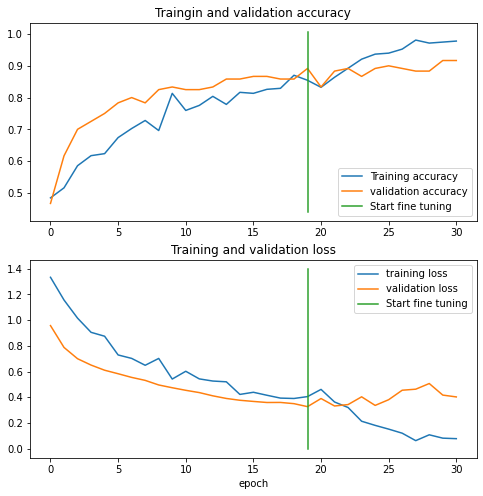

In [220]:
compare_historys(history_1, history_fine_tuned, initial_epoch = 20)

In [221]:
model_1.save("Building_defect_detection_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
